# Churn Explo

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

import src.settings.settings as stg

from src.infrastructure.raw_bank_data import RawBankData
from src.infrastructure.technical_cleaning import DateTransformer, BooleanEncoder

from src.domain.domain_cleaning import FrequencyEncoder, CustomOneHotEncoder, AberrantAgeImputer,\
                                       AberrantNbProduitsImputer, CreditScoreImputer, SalaryImputer,\
                                       BalanceImputer

from src.domain.feature_engineering import SeniorityCreator, AgeClassCreator, CreditScoreAgeRatioCreator,\
                                           BalanceWageRatioCreator, CreditScoreByNProductsCreator

ModuleNotFoundError: No module named 'src'

## Data Dictionary
customers
- **ID_CLIENT** Identifiant du client
- **DATE_ENTREE** Date d'entrée du client
- **NOM** Nom du client
- **PAYS** Pays de naissance
- **SEXE** Sexe
- **AGE** Age du client
- **MEMBRE_ACTIF** Variable booléenne indiquant si le client est actif ou non.
  
  
indicators
- **ID_CLIENT** Identifiant du client
- **BALANCE** Balance du client
- **NB_PRODUITS** Nombre de produits détenus
- **CARTE_CREDIT** Variable booléenne indiquant si le client détient une carte de crédit
- **SALAIRE** Salaire estimé du client
- **SCORE_CREDIT** Score de crédit
- **CHURN** Variable cible indiquant si le client a quitté la banque


In [4]:
# Collect separate datasets

bank_data = RawBankData(remove_nan=False)
customers = bank_data.customers
indicators = bank_data.indicators

## First look before merging

In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID_CLIENT     9950 non-null   object
 1   DATE_ENTREE   9950 non-null   object
 2   PAYS          9950 non-null   object
 3   SEXE          9950 non-null   object
 4   AGE           9950 non-null   int64 
 5   MEMBRE_ACTIF  9950 non-null   object
dtypes: int64(1), object(5)
memory usage: 466.5+ KB


No nan value, only one column with numerical values.

In [6]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID_CLIENT     9950 non-null   object 
 1   BALANCE       9932 non-null   float64
 2   NB_PRODUITS   9950 non-null   int64  
 3   CARTE_CREDIT  9950 non-null   object 
 4   SALAIRE       9721 non-null   float64
 5   SCORE_CREDIT  9391 non-null   float64
 6   CHURN         9950 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 544.3+ KB


Nan values in 3 columns. 3 columns with non numerical values including the target column CHURN.

## Join databases without ID_CLIENT

In [7]:
clients = pd.merge(customers, indicators, on=stg.CUSTOMERS_ID_CLIENT, how='inner')
clients = clients.drop(columns=stg.CUSTOMERS_ID_CLIENT)
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE_ENTREE   9950 non-null   object 
 1   PAYS          9950 non-null   object 
 2   SEXE          9950 non-null   object 
 3   AGE           9950 non-null   int64  
 4   MEMBRE_ACTIF  9950 non-null   object 
 5   BALANCE       9932 non-null   float64
 6   NB_PRODUITS   9950 non-null   int64  
 7   CARTE_CREDIT  9950 non-null   object 
 8   SALAIRE       9721 non-null   float64
 9   SCORE_CREDIT  9391 non-null   float64
 10  CHURN         9950 non-null   object 
dtypes: float64(3), int64(2), object(6)
memory usage: 932.8+ KB


In [8]:
clients.isnull().sum()

DATE_ENTREE       0
PAYS              0
SEXE              0
AGE               0
MEMBRE_ACTIF      0
BALANCE          18
NB_PRODUITS       0
CARTE_CREDIT      0
SALAIRE         229
SCORE_CREDIT    559
CHURN             0
dtype: int64

Inner join give the same amount of rows than in customers and indicators dataframes. Thus there is a 
full matching between columns ID_CLIENT present in customers and indicators dataframes.

# 0. First look at values

In [9]:
print("Columns unique values :")    
print(clients.apply(pd.Series.nunique))

Columns unique values :
DATE_ENTREE       66
PAYS               3
SEXE               2
AGE              110
MEMBRE_ACTIF       2
BALANCE         6334
NB_PRODUITS        8
CARTE_CREDIT       2
SALAIRE         9720
SCORE_CREDIT     460
CHURN              2
dtype: int64


We consider a column as categorical if it has less than 10 unique values.

In [10]:
categorical_columns = [stg.PAYS, stg.SEXE, stg.MEMBRE_ACTIF, stg.NB_PRODUITS, stg.CARTE_CREDIT, stg.CHURN]
numerical_columns = [stg.DATE_ENTREE, stg.AGE, stg.BALANCE, stg.SALAIRE, stg.SCORE_CREDIT]

# 1. Values in categorical columns

In [11]:
for column in categorical_columns:
    print(f'Values in {column}: {sorted(clients[column].unique())}')

Values in PAYS: ['Allemagne', 'Espagne', 'France']
Values in SEXE: ['F', 'H']
Values in MEMBRE_ACTIF: ['No', 'Yes']
Values in NB_PRODUITS: [1, 2, 3, 4, 15, 16, 17, 18]
Values in CARTE_CREDIT: ['No', 'Yes']
Values in CHURN: ['No', 'Yes']


We notice a gap in NB_PRODUITS values.

## Aberrant values in categorical columns

In [12]:
print('Number of rows with NB_PRODUITS over 4: ', len(clients[clients[stg.NB_PRODUITS]>4][stg.NB_PRODUITS]))

Number of rows with NB_PRODUITS over 4:  199


We will consider values in NB_PRODUITS over 4 as aberrant.

In [13]:
clients_aberrant_nbproduits = clients[clients[stg.NB_PRODUITS]>4]

## Global churner ratio

In [14]:
churner_ratio = len(clients.query(f'{stg.CHURN} == "Yes"')) / len(clients)
churner_ratio

0.2037185929648241

The classification problem is quite unbalanced, we will have to take this into account in our analysis.
However, the global churner ratio seems high and makes me wonder if we got a representative database.

## Other categorical columns

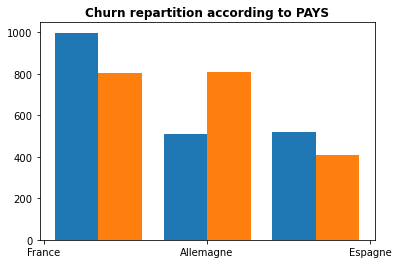

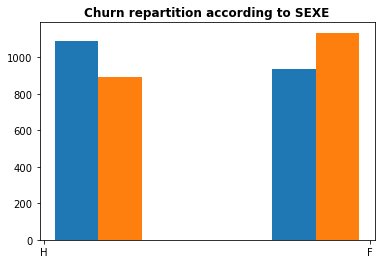

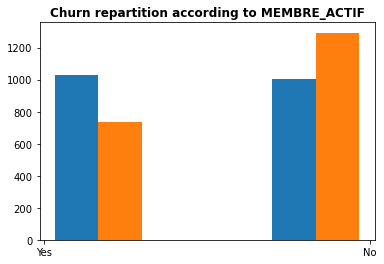

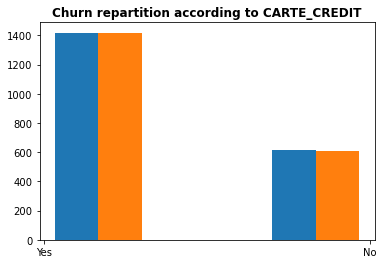

In [15]:
for column in [stg.PAYS, stg.SEXE, stg.MEMBRE_ACTIF, stg.CARTE_CREDIT]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist([clients.sample(frac=churner_ratio)[column], clients.query('CHURN == "Yes"')[column]],bins=3)
    plt.title(f'Churn repartition according to {column}', fontweight ="bold")

Explanation:
- Orange higher than blue => value has a positive influence on CHURN = Yes when compared to the global churner ratio.
- Blue higher than blue => value has a negative influence on CHURN = Yes when compared to the global churner ratio.
- Orange and blue have same hight => value has no influence on CHURN = Yes when compared to the global churner ratio.

Examples:
- There are more churners among women than among men + women. Thus, SEXE = F has a positive influence on CHURN = Yes.
- There are less churners among active members than among active members + unactive members.
- CARTE_CREDIT value has no influence (taken alone) on the churner ratio.

Conclusion:
- SEXE, MEMBRE_ACTIF and PAYS have evident influence on the churner ratio.
- CARTE_CREDIT has (by itself) no influence on the churner ratio.

# 2. Values in numerical columns

## DATE_ENTREE column

In [16]:
dt = DateTransformer(stg.DATE_FORMAT)
clients = dt.transform(clients)
clients[stg.DATE_ENTREE].min(), clients[stg.DATE_ENTREE].max()

(Timestamp('2010-01-01 00:00:00'), Timestamp('2020-06-01 00:00:00'))

Only 66 different values for DATE_ENTREE which correspond to more than 10 years. Let's investigate!

In [17]:
year = clients[stg.DATE_ENTREE].apply(lambda x: x.year)
month = clients[stg.DATE_ENTREE].apply(lambda x: x.month)
day = clients[stg.DATE_ENTREE].apply(lambda x: x.day)

In [18]:
for elt in [year, month, day]:
    print(sorted(elt.unique()))

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
[1, 2, 3, 4, 5, 6]
[1]


In [19]:
print('Every first 6 months in years 2010 to 2020 present in dataframe ? >>> ',
      len(year.unique())*len(month.unique()) - 66 == 0)

Every first 6 months in years 2010 to 2020 present in dataframe ? >>>  True


Observations:
- We have data for the first 6 months between 2010 and 2020!
- Create a seniority column seems to be a good idea.

## AGE column

In [20]:
print(sorted(clients[stg.AGE].unique()))

[18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 88, 92, 114, 116, 117, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 147, 151, 152, 155, 156, 157, 158, 159, 164, 165, 166]


In [21]:
len(clients[clients[stg.AGE]>100][stg.AGE])

150

Gape of values between 92 and 114. We will consider values over 100 as aberrant values.

In [22]:
clients_aberrant_age = clients[clients[stg.AGE]>100]

## BALANCE column

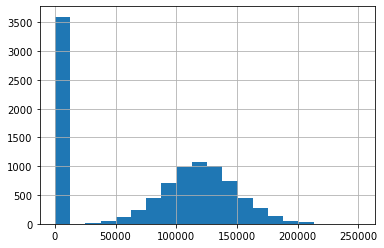

In [23]:
#Looking for aberrant values
clients[stg.BALANCE].hist(bins=20)

Observations:
- High number of zeros. More than probably those zeros correspond to negative balances
- Perhaps aberrant values over 200k. We plot cumulative histogram to verify.

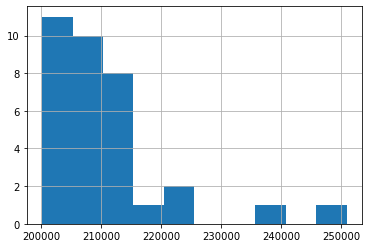

In [24]:
# Looking for aberrant values
clients[clients[stg.BALANCE] > 200000][stg.BALANCE].hist()

It isn't clear the two extremal values should be considered as aberrant. They are just higher than others.

## SALAIRE column

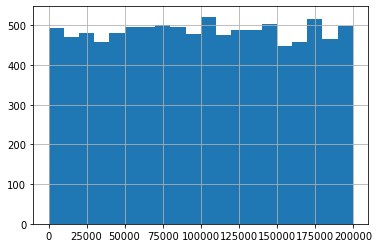

In [25]:
#Looking for aberrant values
clients[stg.SALAIRE].hist(bins=20)

Observations:
- No aberrant values.
- It is weird to have an uniform repartition of wages in a population.

## SCORE_CREDIT column

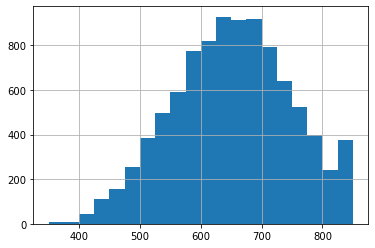

In [26]:
#Looking for aberrant values
clients[stg.SCORE_CREDIT].hist(bins=20)

No aberrant value. A stack on the highest value, probably because nobody can have a credit score greater than 850.

## Churner repartition for numerical columns without aberrant values

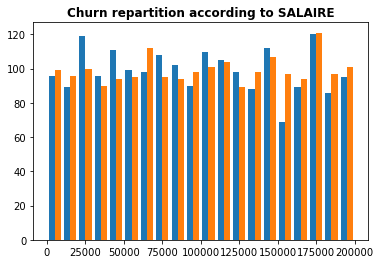

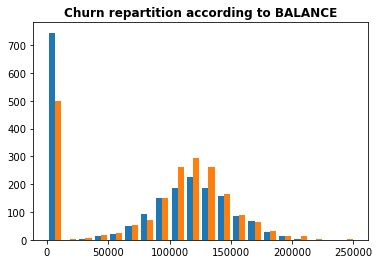

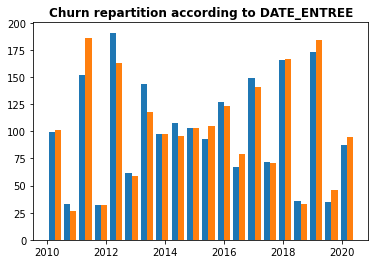

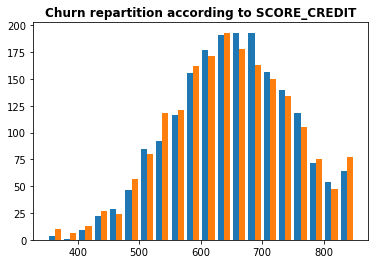

In [101]:
for column in [stg.SALAIRE, stg.BALANCE, stg.DATE_ENTREE, stg.SCORE_CREDIT]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist([clients.sample(frac=churner_ratio)[column],
             clients.query('CHURN == "Yes"')[column]],bins=20)
    plt.title(f'Churn repartition according to {column}', fontweight ="bold")

Observations:
- BALANCE = 0 has a negative influence on churner ratio
- For BALANCE > 0, there seem to have a positive influence for BALANCE in [100k, 150k] and no influence outside.
- DATE_ENTREE, SALAIRE and SCORE_CREDIT (by themself!) don't seem to have an influence on the churner ratio.

## Missing values 

In [27]:
clients_noscore = clients[clients[stg.SCORE_CREDIT].isnull()]
clients_nosalary = clients[clients[stg.SALAIRE].isnull()]
clients_nobalance = clients[clients[stg.BALANCE].isnull()]

print('Are clients without salary all clients without score ? >>> ',
      clients_noscore[stg.SALAIRE].isnull().sum() == clients_nosalary[stg.SALAIRE].isnull().sum())
print('Are clients without balance all clients without salary ? >>> ',
      clients_nosalary[stg.BALANCE].isnull().sum() == clients_nobalance[stg.BALANCE].isnull().sum())

Are clients without salary all clients without score ? >>>  True
Are clients without balance all clients without salary ? >>>  True


Chain of implications for missing values:

Nan BALANCE => Nan SALAIRE => Nan CREDIT_SCORE

# 2. Aberrant and missing values

## 2.1 Aberrant values 

### Aberrant AGE 

In [28]:
clients_aberrant_age[[stg.SCORE_CREDIT, stg.SALAIRE, stg.BALANCE, stg.NB_PRODUITS]].apply(pd.Series.nunique)

SCORE_CREDIT     0
SALAIRE          0
BALANCE         84
NB_PRODUITS      4
dtype: int64

Clients with aberrant age have only nan values in SALAIRE and SCORE_CREDIT columns.

In [29]:
sorted(clients_aberrant_age[stg.NB_PRODUITS].unique())

[15, 16, 17, 18]

Clients with aberrant age have aberrant values in NB_PRODUITS column. Meaning that the dataframe formed by rows 
with aberrant AGE values is included in the dataframe formed by rows with aberrant NB_PRODUITS values.

### Splitting dataframe according to aberrant NB_PRODUITS

In [30]:
clients_aberrant_nbproduits[[stg.SCORE_CREDIT, stg.SALAIRE, stg.BALANCE, stg.AGE]].apply(pd.Series.nunique)

SCORE_CREDIT      0
SALAIRE           0
BALANCE         117
AGE              66
dtype: int64

In [31]:
# Drop empty columns from clients with aberrant NB_PRODUITS
ab_nbprod = clients_aberrant_nbproduits.drop(columns=[stg.SALAIRE, stg.SCORE_CREDIT])
ab_nbprod.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 1 to 9794
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE_ENTREE   199 non-null    object 
 1   PAYS          199 non-null    object 
 2   SEXE          199 non-null    object 
 3   AGE           199 non-null    int64  
 4   MEMBRE_ACTIF  199 non-null    object 
 5   BALANCE       181 non-null    float64
 6   NB_PRODUITS   199 non-null    int64  
 7   CARTE_CREDIT  199 non-null    object 
 8   CHURN         199 non-null    object 
dtypes: float64(1), int64(2), object(6)
memory usage: 15.5+ KB


In [32]:
clients_nobalance

DATE_ENTREE       PAYS SEXE  AGE MEMBRE_ACTIF  BALANCE  NB_PRODUITS  \
210   2015-05-01     France    H  128          Yes      NaN           16   
999   2018-03-01     France    H  130           No      NaN           16   
2181  2015-01-01     France    F  136          Yes      NaN           15   
2339  2015-06-01     France    F  125          Yes      NaN           16   
2842  2012-02-01    Espagne    F  124           No      NaN           16   
4119  2019-06-01    Espagne    F  158          Yes      NaN           15   
4720  2014-02-01     France    H  135           No      NaN           15   
4741  2016-06-01  Allemagne    F  124           No      NaN           18   
5378  2012-03-01  Allemagne    F  152          Yes      NaN           15   
6647  2020-04-01  Allemagne    F  139          Yes      NaN           15   
6817  2015-04-01     France    F  130           No      NaN           16   
8374  2012-03-01     France    F  132           No      NaN           16   
8481  2020-01-01  Allemagne    F  135          Yes      NaN           15   
8557  2012-01-01  Allemagne    H  123          Yes      NaN           15   
9330  2019-02-01    Espagne    F  151           No      NaN           15   
9356  2018-03-01     France    H  124          Yes      NaN           16   
9390  2011-05-01     France    H  142          Yes      NaN           15   
9652  2016-05-01     France    H  135          Yes      NaN           15   

     CARTE_CREDIT  SALAIRE  SCORE_CREDIT CHURN  
210            No      NaN           NaN    No  
999           Yes      NaN           NaN    No  
2181           No      NaN           NaN    No  
2339           No      NaN           NaN    No  
2842          Yes      NaN           NaN    No  
4119          Yes      NaN           NaN    No  
4720          Yes      NaN           NaN    No  
4741          Yes      NaN           NaN   Yes  
5378          Yes      NaN           NaN   Yes  
6647          Yes      NaN           NaN   Yes  
6817          Yes      NaN           NaN    No  
8374          Yes      NaN           NaN    No  
8481          Yes      NaN           NaN   Yes  
8557          Yes      NaN           NaN    No  
9330          Yes      NaN           NaN   Yes  
9356          Yes      NaN           NaN    No  
9390          Yes      NaN           NaN    No  
9652           No      NaN           NaN    No

Don't notice any kind of pattern.

All missing BALANCE values are in this dataframe. Chain of implications :

Nan BALANCE => Aberrant age => Aberrant NB_PRODUITS => Nan SALAIRE => Nan CREDIT_SCORE

In [33]:
clients_non_aberrant_nbproduits = clients[clients[stg.NB_PRODUITS] < 10]
clients_non_aberrant_nbproduits.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9751 entries, 0 to 9949
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE_ENTREE   9751 non-null   datetime64[ns]
 1   PAYS          9751 non-null   object        
 2   SEXE          9751 non-null   object        
 3   AGE           9751 non-null   int64         
 4   MEMBRE_ACTIF  9751 non-null   object        
 5   BALANCE       9751 non-null   float64       
 6   NB_PRODUITS   9751 non-null   int64         
 7   CARTE_CREDIT  9751 non-null   object        
 8   SALAIRE       9721 non-null   float64       
 9   SCORE_CREDIT  9391 non-null   float64       
 10  CHURN         9751 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(5)
memory usage: 914.2+ KB


In [34]:
non_ab_nbprod_nosal = clients_non_aberrant_nbproduits[clients_non_aberrant_nbproduits[stg.SALAIRE].isnull()]
non_ab_nbprod_nosal

DATE_ENTREE       PAYS SEXE  AGE MEMBRE_ACTIF    BALANCE  NB_PRODUITS  \
9     2018-02-01     France    F   26          Yes  107508.93            2   
281   2016-03-01    Espagne    F   32           No  132835.56            1   
343   2020-02-01  Allemagne    H   55          Yes   98710.89            1   
556   2018-02-01  Allemagne    H   41          Yes  127892.57            2   
670   2017-03-01    Espagne    H   60          Yes       0.00            2   
1031  2018-02-01     France    F   36          Yes  110414.48            1   
1807  2013-03-01     France    F   60          Yes  143262.04            1   
2115  2014-01-01     France    F   39          Yes  130694.89            2   
2758  2010-06-01     France    H   33          Yes  118327.17            2   
2775  2015-03-01     France    H   36           No       0.00            2   
2863  2019-03-01     France    H   31          Yes  132512.26            1   
3387  2012-01-01     France    H   34          Yes       0.00            2   
3689  2011-02-01    Espagne    F   33           No       0.00            2   
3906  2017-01-01     France    H   50           No       0.00            2   
3995  2020-03-01  Allemagne    H   28           No  143988.00            2   
4259  2013-02-01    Espagne    H   19          Yes  112615.86            1   
4522  2013-03-01     France    F   21          Yes   98993.02            1   
4661  2018-02-01     France    H   37           No       0.00            2   
5593  2019-01-01     France    H   26           No       0.00            2   
6057  2015-04-01     France    F   67          Yes  113978.97            2   
6656  2012-02-01    Espagne    F   35          Yes       0.00            1   
7213  2015-04-01  Allemagne    H   23          Yes  132725.10            1   
7388  2013-01-01  Allemagne    H   28          Yes   76656.40            2   
7442  2016-06-01     France    F   44           No       0.00            2   
7476  2014-01-01    Espagne    H   35          Yes  116662.96            2   
8113  2020-04-01     France    H   58          Yes  149117.31            1   
8670  2014-03-01     France    H   41           No       0.00            2   
9008  2020-05-01     France    F   38          Yes  106831.69            1   
9278  2019-02-01     France    H   46           No   91857.66            1   
9310  2014-02-01     France    H   40          Yes   97339.99            1   

     CARTE_CREDIT  SALAIRE  SCORE_CREDIT CHURN  
9             Yes      NaN           NaN    No  
281            No      NaN           NaN    No  
343           Yes      NaN           NaN   Yes  
556            No      NaN           NaN    No  
670           Yes      NaN           NaN    No  
1031          Yes      NaN           NaN    No  
1807          Yes      NaN           NaN    No  
2115          Yes      NaN           NaN   Yes  
2758          Yes      NaN           NaN    No  
2775          Yes      NaN           NaN    No  
2863          Yes      NaN           NaN    No  
3387          Yes      NaN           NaN    No  
3689           No      NaN           NaN    No  
3906          Yes      NaN           NaN    No  
3995          Yes      NaN           NaN   Yes  
4259          Yes      NaN           NaN    No  
4522          Yes      NaN           NaN    No  
4661          Yes      NaN           NaN    No  
5593           No      NaN           NaN    No  
6057           No      NaN           NaN    No  
6656          Yes      NaN           NaN    No  
7213          Yes      NaN           NaN    No  
7388          Yes      NaN           NaN    No  
7442           No      NaN           NaN    No  
7476          Yes      NaN           NaN    No  
8113          Yes      NaN           NaN    No  
8670           No      NaN           NaN    No  
9008           No      NaN           NaN    No  
9278          Yes      NaN           NaN   Yes  
9310           No      NaN           NaN    No

Don't see any kind of pattern here.

I see two natural options for aberrant values. First we remove lines with aberrant NB_PRODUITS so that
we don't have to handle neither aberrant NB_PRODUITS neither aberrant AGE and in bonus, we won't have to handle
missing BALANCE values. The second option would be to look at repartition of churners in aberrant values of
NB_PRODUITS and AGE and see what can be done.

## Plots : columns with aberrant values

Text(0.5, 1.0, 'Churn repartition according to abberrant AGE')

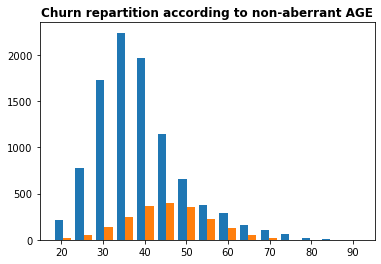

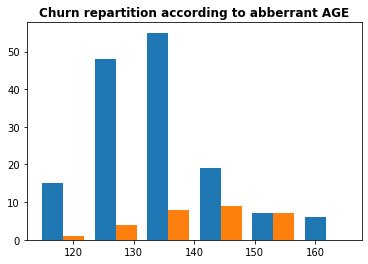

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_non_aberrant_nbproduits[stg.AGE],
         clients_non_aberrant_nbproduits.query('CHURN == "Yes"')[stg.AGE]],bins=15)
plt.title(f'Churn repartition according to non-aberrant AGE', fontweight ="bold")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_aberrant_age[stg.AGE],
         clients_aberrant_age.query('CHURN == "Yes"')[stg.AGE]],bins=6)
plt.title(f'Churn repartition according to abberrant AGE', fontweight ="bold")

Observation: repartition of churners is similar in aberrant AGE and non aberrant AGE distributions. We could
change aberrant values in AGE to non-aberrant ones by applying aberrant_value -> aberrant_value%100.     

Text(0.5, 1.0, 'Churn repartition according to abberrant AGE')

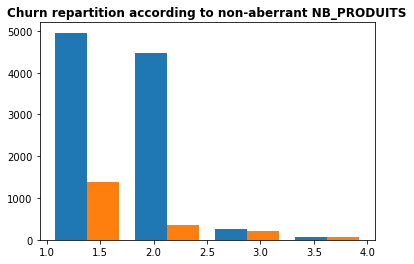

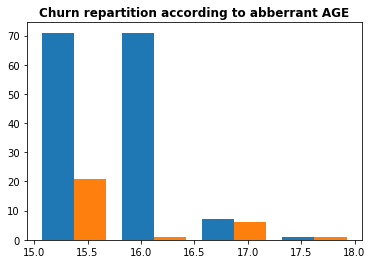

In [69]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_non_aberrant_nbproduits[stg.NB_PRODUITS],
         clients_non_aberrant_nbproduits.query('CHURN == "Yes"')[stg.NB_PRODUITS]],bins=4)
plt.title(f'Churn repartition according to non-aberrant NB_PRODUITS', fontweight ="bold")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_aberrant_age[stg.NB_PRODUITS],
         clients_aberrant_age.query('CHURN == "Yes"')[stg.NB_PRODUITS]],bins=4)
plt.title(f'Churn repartition according to abberrant AGE', fontweight ="bold")

Observation: repartition of churners is similar in aberrant NB_PRODUITS and non aberrant NB_PRODUITS distributions. 
We could change aberrant values in NB_PRODUITS to non-aberrant ones by applying aberrant_value -> aberrant_value%14.

## Conclusion for aberrant values

If we manage missing values, we could input aberrant values by:
- mapping aberrant_age to aberrant_age % 100.
- mapping aberrant_nb_produits to aberrant_nb_produits % 14 (mapping 15 to 1, 16 to 2, etc)

## 2.2 Missing values

In [35]:
# Missing value proportions
pd.DataFrame(clients[[stg.SCORE_CREDIT, stg.SALAIRE, stg.BALANCE]].isnull().mean(),
             columns=['missing_value_proportions'])\
  .sort_values(by='missing_value_proportions', ascending=False)

missing_value_proportions
SCORE_CREDIT                   0.056181
SALAIRE                        0.023015
BALANCE                        0.001809

### BALANCE column

The really low proportion of missing BALANCE values can be inputed to the median without changing the repartition of churners in the BALANCE column.

### SALAIRE column

In [36]:
# Proportion of churners in clients with missing values in SALAIRE
len(clients_nosalary.query('CHURN == "Yes"')) / len(clients_nosalary)

0.1965065502183406

Roughly the same proportion of churners in clients with missing values in SALAIRE. We might try to input a fixed
value for missing SALAIRE values, for instance 0.

Text(0.5, 1.0, 'Churn repartition according to filling SALAIRE')

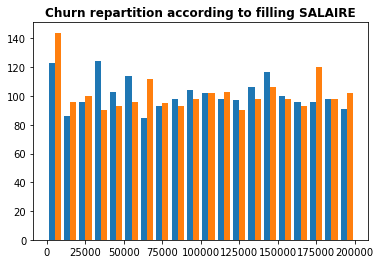

In [117]:
# We try to fill missing values in SALAIRE by 0 to see if there is some significative change in the
# repartition of churners.
clients_wage_filled = clients.copy()
clients_wage_filled[stg.SALAIRE] = clients_wage_filled[stg.SALAIRE].fillna(value=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_wage_filled.sample(frac=churner_ratio)[stg.SALAIRE],
         clients_wage_filled.query('CHURN == "Yes"')[stg.SALAIRE]],bins=20)
plt.title(f'Churn repartition according to filling SALAIRE', fontweight ="bold")

No significative change, it is an acceptable strategy to input missing SALAIRE values to 0.

### SCORE_CREDIT column

In [37]:
# Proportion of churners in clients with missing values in SALAIRE
len(clients_noscore.query('CHURN == "Yes"')) / len(clients_noscore)

0.2075134168157424

As for SALAIRE column, we obtain roughly the same proportion of churners in clients with missing values
in SCORE_CREDIT. We might try to input a fixed value for missing SCORE_CREDIT values, for instance 0 (or 350 which
is the smallest credit score possible). 

Text(0.5, 1.0, 'Churn repartition according to filling SCORE_CREDIT with zeros')

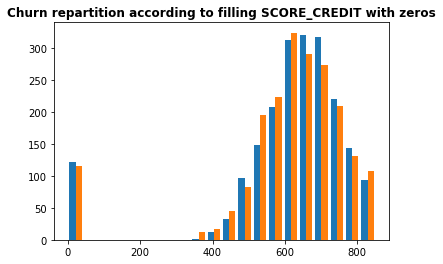

In [121]:
# We try to fill missing values in SALAIRE by 0 to see if there is some significative change in the
# repartition of churners.
clients_score_filled_0 = clients.copy()
clients_score_filled_0[stg.SCORE_CREDIT] = clients_wage_filled[stg.SCORE_CREDIT].fillna(value=0)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_score_filled_0.sample(frac=churner_ratio)[stg.SCORE_CREDIT],
         clients_score_filled_0.query('CHURN == "Yes"')[stg.SCORE_CREDIT]],bins=20)
plt.title(f'Churn repartition according to filling SCORE_CREDIT with zeros', fontweight ="bold")

Text(0.5, 1.0, 'Churn repartition according to filling SCORE_CREDIT with zeros')

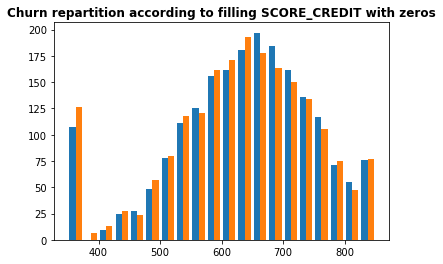

In [122]:
clients_score_filled_350 = clients.copy()
clients_score_filled_350[stg.SCORE_CREDIT] = clients_wage_filled[stg.SCORE_CREDIT].fillna(value=350)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([clients_score_filled_350.sample(frac=churner_ratio)[stg.SCORE_CREDIT],
         clients_score_filled_350.query('CHURN == "Yes"')[stg.SCORE_CREDIT]],bins=20)
plt.title(f'Churn repartition according to filling SCORE_CREDIT with zeros', fontweight ="bold")

We keep those 2 different possibilities in mind. We will perhaps have a clear better choice to make after feature
engineering.

## Input values strategy

1) Drop rows with missing values in SCORE_CREDIT to train the model.

2) Use the following input values strategy to make predictions: 
- Input BALANCE missing values by BALANCE median.
- Input SALAIRE missing values by 0.
- Input SCORE_CREDIT missing values by 0 or 350.

- Map : AGE --> AGE % 100
- Map : NB_PRODUITS --> NB_PRODUITS % 14

# 3. Correlation matrices

In [38]:
encoder = Pipeline(steps=[
    ("DateTransformer", DateTransformer(stg.DATE_FORMAT)),
    ("BooleanEncoder", BooleanEncoder([stg.SEXE, stg.MEMBRE_ACTIF, stg.CARTE_CREDIT, stg.CHURN])),
    ("SeniorityCreator", SeniorityCreator('ANCIENNETE')),
    ("FrequencyEncoder", FrequencyEncoder([stg.PAYS]))
])

clients_encode = encoder.fit_transform(clients)
clients_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DATE_ENTREE   9950 non-null   datetime64[ns]
 1   PAYS          9950 non-null   float64       
 2   SEXE          9950 non-null   int64         
 3   AGE           9950 non-null   int64         
 4   MEMBRE_ACTIF  9950 non-null   int64         
 5   BALANCE       9932 non-null   float64       
 6   NB_PRODUITS   9950 non-null   int64         
 7   CARTE_CREDIT  9950 non-null   int64         
 8   SALAIRE       9721 non-null   float64       
 9   SCORE_CREDIT  9391 non-null   float64       
 10  CHURN         9950 non-null   int64         
 11  ANCIENNETE    9950 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(7)
memory usage: 1010.5 KB


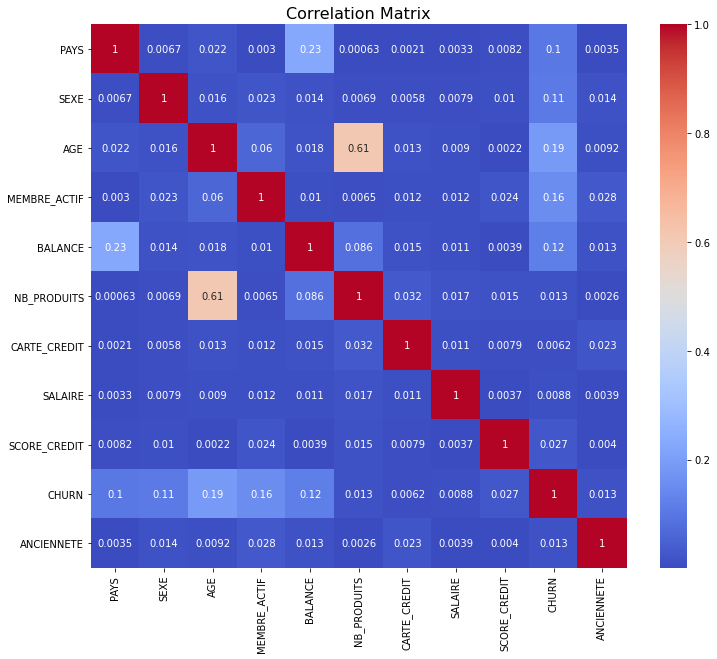

In [160]:
# Correlation matrix of clients with aberrant and missing values
fig = plt.figure(figsize=(12,10))
sns.heatmap(clients_encode.corr().abs(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16);

It is interesting to see quite high correlation between NB_PRODUITS and AGE. However, this can easily be explained by
the fact that the set of rows with aberrant AGE value lies in the set of rows with aberrant NB_PRODUITS values. Let's
check out!

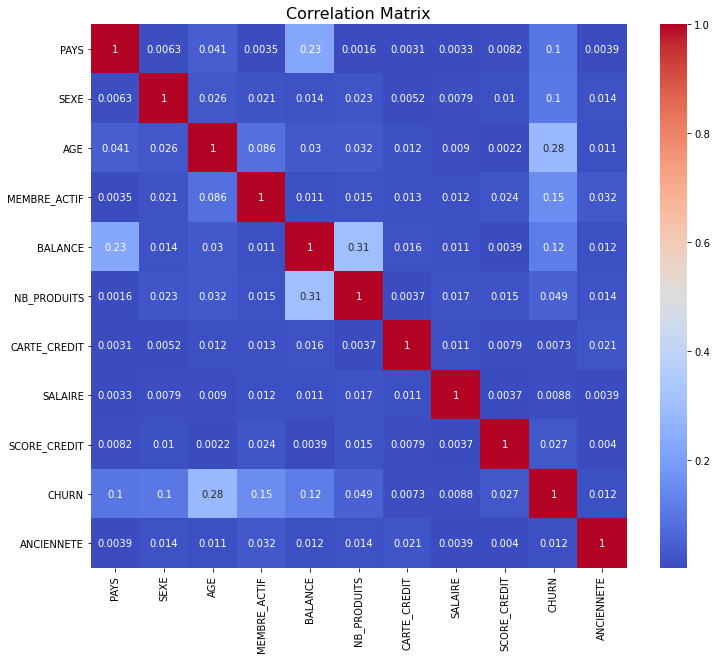

In [161]:
clients_non_aberrant_nbproduits_encode = clients_encode[clients_encode[stg.NB_PRODUITS] < 10]

fig = plt.figure(figsize=(12,10))
sns.heatmap(clients_non_aberrant_nbproduits_encode.corr().abs(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16);

Indeed, if we take off rows with aberrant NB_PRODUIT values, we see that the columns are quite decorelated. Moreover, NB_PRODUITS is not as highly correlated with CHURN as previous analysis seemed to show. Let's try a one hot encoder on
NB_PRODUITS to see if correlations happen

In [39]:
onehot = CustomOneHotEncoder([stg.NB_PRODUITS])

clients_non_aberrant_nbproduits_ohencode = onehot.fit_transform(clients_non_aberrant_nbproduits_encode)
clients_non_aberrant_nbproduits_ohencode.info()

NameError: name 'clients_non_aberrant_nbproduits_encode' is not defined

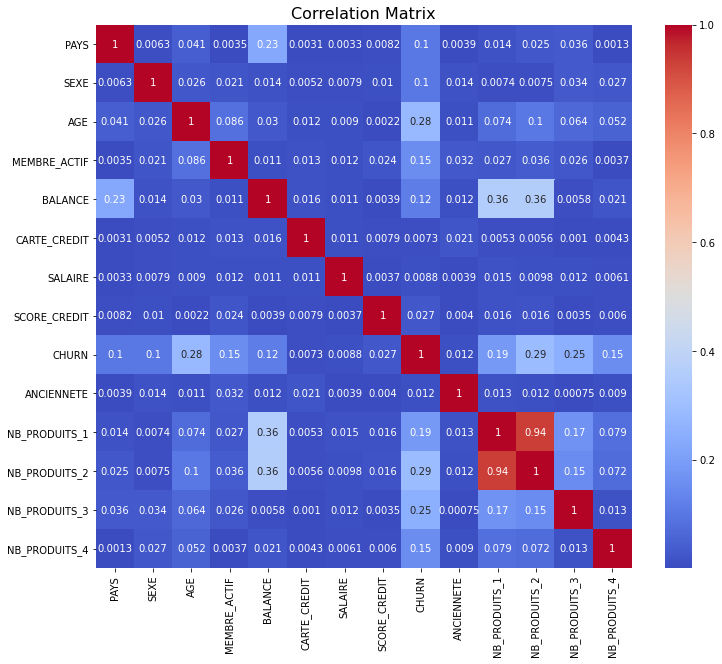

In [163]:
fig = plt.figure(figsize=(12,10))
sns.heatmap(clients_non_aberrant_nbproduits_ohencode.corr().abs(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16);

Now we see correlations between CHURN and NB_PRODUITS appear!

For know, we keep all columns, it would be interesting to see if and how the model uses CARTE_CREDIT, SALAIRE, SCORE_CREDIT and ANCIENNETE columns which are apparently quite uncorrelated to CHURN.

# 4. Feature engineering

Several ideas for feature engineering:
- Create age categories capting different repartitions of churners: 0 to 35, 36 to 45, 46 to 67 and 68 to 100 (must be done after inputing aberrant AGE values)
- Create ratio of SCORE_CREDIT by AGE (should also be done after inputing abberant AGE values)
- Create ratio of SCORE_CREDIT by NB_PRODUIT (should be done after imputing aberrant NB_PRODUITS values)
- Create ratio of BALANCE by SALAIRE (must input missing SALAIRE values by 1 instead of 0)
- Create BALANCE - SALAIRE (input missing SALAIRE values by 0 here)

In [40]:
# Needs 4 different pipelines according to whether we choose to create the ratio or the difference of BALANCE and 
# SALAIRE and to impute SCORE_CREDIT to 0 or to 350.

imputer_gen = Pipeline(steps=[
    ("DateTransformer", DateTransformer(stg.DATE_FORMAT)),
    ("BooleanEncoder", BooleanEncoder([stg.SEXE, stg.MEMBRE_ACTIF, stg.CARTE_CREDIT, stg.CHURN])),
    ("SeniorityCreator", SeniorityCreator('ANCIENNETE')),
    ("FrequencyEncoder", FrequencyEncoder([stg.PAYS])),
    ("AberrantAgeImputer", AberrantAgeImputer()),
    ("AgeClassCreator", AgeClassCreator(stg.CATEGORIE_AGE)),
    ("AberrantNbProduitsImputer", AberrantNbProduitsImputer()),
    ("BalanceImputer", BalanceImputer())
])

imputer_score0 = Pipeline(steps=[
    ("GeneralImputer", imputer_gen),
    ("CreditScoreImputer", CreditScoreImputer(0)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator",CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("OneHotEncoder", CustomOneHotEncoder([stg.NB_PRODUITS])),
])

imputer_score350 = Pipeline(steps=[
    ("GeneralImputer", imputer_gen),
    ("CreditScoreImputer", CreditScoreImputer(350)),
    ("CreditScoreAgeRatioCreator", CreditScoreAgeRatioCreator(stg.RATIO_SCORE_CREDIT_AGE)),
    ("CreditScoreByNProductsCreator",CreditScoreByNProductsCreator(stg.RATIO_SCORE_CREDIT_NB_PRODUITS)),
    ("OneHotEncoder", CustomOneHotEncoder([stg.NB_PRODUITS])),
])

pipe_score0_ratio = Pipeline(steps=[
    ("ImputerScore0", imputer_score0),
    ("SalaryImputer", SalaryImputer(1)),
    ("BalanceWageRatioCreator", BalanceWageRatioCreator(stg.RATIO_BALANCE_SALAIRE))
])

pipe_score350_ratio = Pipeline(steps=[
    ("ImputerScore350", imputer_score350),
    ("SalaryImputer", SalaryImputer(1)),
    ("BalanceWageRatioCreator", BalanceWageRatioCreator(stg.RATIO_BALANCE_SALAIRE))
])

## 4.1 Score 0, ratio

In [42]:
score0_ratio_clients = pipe_score0_ratio.fit_transform(clients)
score0_ratio_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   DATE_ENTREE                     9950 non-null   datetime64[ns]
 1   PAYS                            9950 non-null   float64       
 2   SEXE                            9950 non-null   int64         
 3   AGE                             9950 non-null   int64         
 4   MEMBRE_ACTIF                    9950 non-null   int64         
 5   BALANCE                         9950 non-null   float64       
 6   CARTE_CREDIT                    9950 non-null   int64         
 7   SALAIRE                         9950 non-null   float64       
 8   SCORE_CREDIT                    9950 non-null   float64       
 9   CHURN                           9950 non-null   int64         
 10  ANCIENNETE                      9950 non-null   int64         
 11  CATE

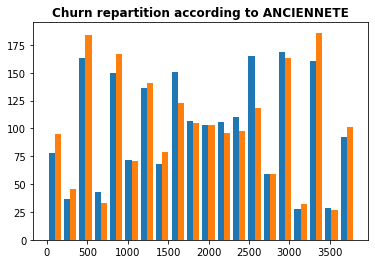

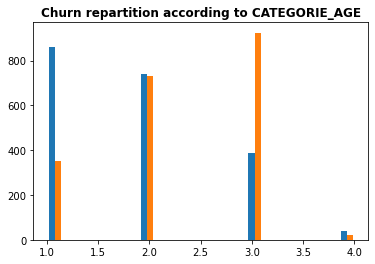

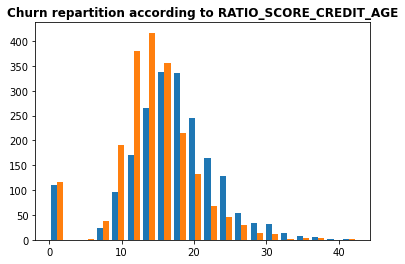

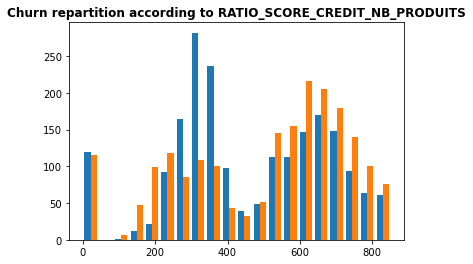

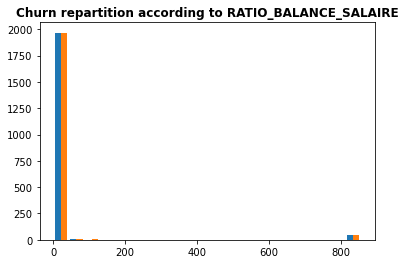

In [178]:
score0_ratio_new_col = ['ANCIENNETE', 'CATEGORIE_AGE', 'RATIO_SCORE_CREDIT_AGE', 'RATIO_SCORE_CREDIT_NB_PRODUITS',
                        'RATIO_BALANCE_SALAIRE']

for column in score0_ratio_new_col:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist([score0_ratio_clients.sample(frac=churner_ratio)[column],
             score0_ratio_clients.query('CHURN == 1')[column]],bins=20)
    plt.title(f'Churn repartition according to {column}', fontweight ="bold")

Observations:
- We see influence of CATEGORIE_AGE, RATIO_SCORE_CREDIT_AGE and RATIO_SCORE_CREDIT_NB_PRODUITS on the churner ratio.
- ANCIENNETE column doesn't seem to have influence (by itself) on the churner ratio. (It was already noticed on the correlation matrix).
- The RATIO_BALANCE_SALAIRE column needs a stronger analysis.

Text(0.5, 1.0, 'Churn repartition according to RATIO_BALANCE_SALAIRE < 1')

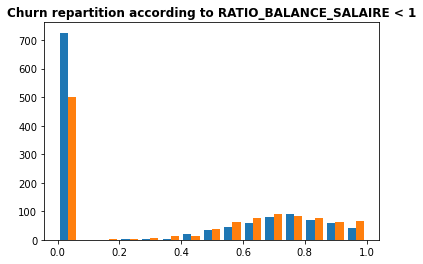

In [184]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([score0_ratio_clients.query('RATIO_BALANCE_SALAIRE < 1').sample(frac=churner_ratio)['RATIO_BALANCE_SALAIRE'],
         score0_ratio_clients.query('RATIO_BALANCE_SALAIRE < 1 and CHURN == 1')['RATIO_BALANCE_SALAIRE']],bins=15)
plt.title(f'Churn repartition according to RATIO_BALANCE_SALAIRE < 1', fontweight ="bold")

Negative influence of RATIO_BALANCE_SALAIRE = 0 on churners but this information is redundant with observations of the
BALANCE column.

Text(0.5, 1.0, 'Churn repartition according to RATIO_BALANCE_SALAIRE >= 1 and RATIO_BALANCE_SALAIRE < 20')

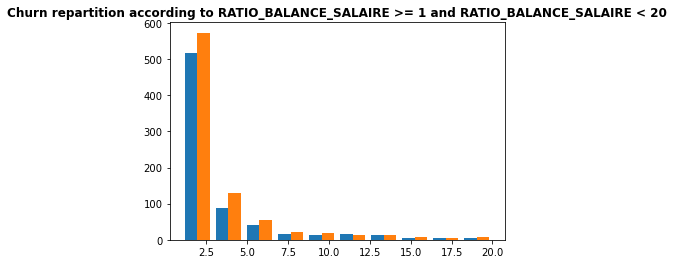

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([score0_ratio_clients.query('RATIO_BALANCE_SALAIRE >= 1 and RATIO_BALANCE_SALAIRE < 20')\
                             .sample(frac=churner_ratio)['RATIO_BALANCE_SALAIRE'],
         score0_ratio_clients.query('RATIO_BALANCE_SALAIRE >= 1 and RATIO_BALANCE_SALAIRE < 20 and CHURN == 1')\
         ['RATIO_BALANCE_SALAIRE']],bins=10)
plt.title(f'Churn repartition according to RATIO_BALANCE_SALAIRE >= 1 and RATIO_BALANCE_SALAIRE < 20',
          fontweight ="bold")

Text(0.5, 1.0, 'Churn repartition according to RATIO_BALANCE_SALAIRE >= 20 and RATIO_BALANCE_SALAIRE < 200')

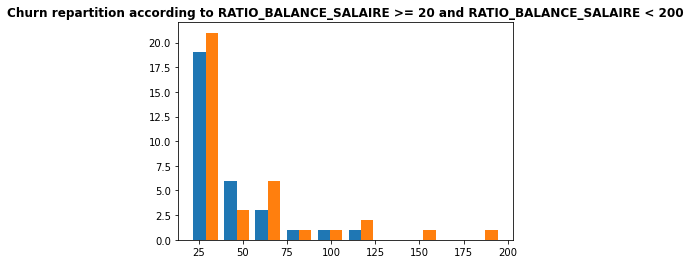

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([score0_ratio_clients.query('RATIO_BALANCE_SALAIRE >= 20 and RATIO_BALANCE_SALAIRE < 200')\
                             .sample(frac=churner_ratio)['RATIO_BALANCE_SALAIRE'],
         score0_ratio_clients.query('RATIO_BALANCE_SALAIRE >= 20 and RATIO_BALANCE_SALAIRE < 200 and CHURN == 1')\
         ['RATIO_BALANCE_SALAIRE']],bins=10)
plt.title(f'Churn repartition according to RATIO_BALANCE_SALAIRE >= 20 and RATIO_BALANCE_SALAIRE < 200',
          fontweight ="bold")

Text(0.5, 1.0, 'Churn repartition according to RATIO_BALANCE_SALAIRE >= 200')

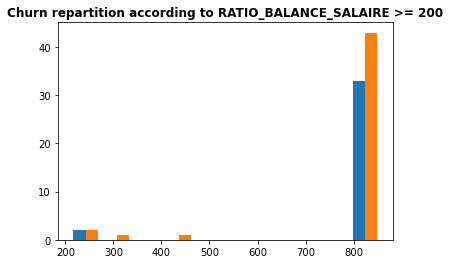

In [188]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([score0_ratio_clients.query('RATIO_BALANCE_SALAIRE >= 200')\
                             .sample(frac=churner_ratio)['RATIO_BALANCE_SALAIRE'],
         score0_ratio_clients.query('RATIO_BALANCE_SALAIRE >= 200 and CHURN == 1')\
         ['RATIO_BALANCE_SALAIRE']],bins=10)
plt.title(f'Churn repartition according to RATIO_BALANCE_SALAIRE >= 200',
          fontweight ="bold")

### Conclusion (BALANCE / SALAIRE, SCORE_0)

- We could keep CATEGORIE_AGE column though it is redondant with AGE column.
- Both ratios involving credit score should be keep.
- The column RATIO_BALANCE_SALAIRE doesn't seem interesting to keep mostly because it does not seem to offer new information and contains outliers.

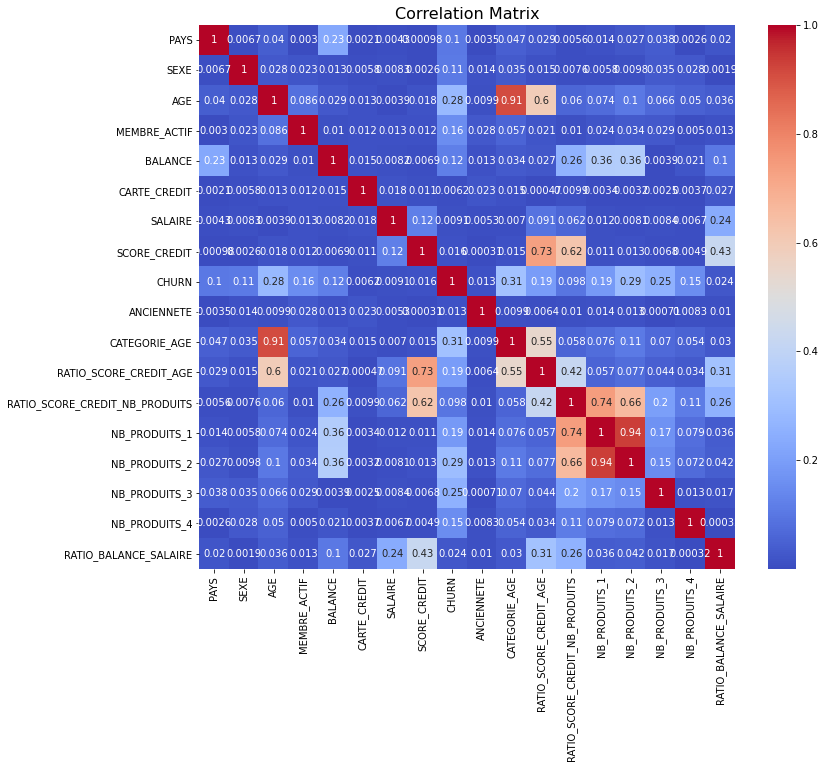

In [190]:
score0_ratio_clients['CATEGORIE_AGE'] = score0_ratio_clients['CATEGORIE_AGE'].astype(float)
fig = plt.figure(figsize=(12,10))
sns.heatmap(score0_ratio_clients.corr().abs(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16);

Correlations appeared where they where expected.
It is funny to notice some correlation between RATIO_BALANCE_SALAIRE and SCORE_CREDIT (and ratios) columns. No interpretation of this fact.

## 4.2 Score 0, difference

In [43]:
pipe_score0_diff = Pipeline(steps=[
    ("ImputerScore0", imputer_score0),
    ("SalaryImputer", SalaryImputer(0))
])

score0_diff_clients = pipe_score0_diff.fit_transform(clients)
score0_diff_clients['DIFFERENCE_BALANCE_SALAIRE'] = score0_diff_clients['BALANCE'] - score0_diff_clients['SALAIRE']
score0_diff_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   DATE_ENTREE                     9950 non-null   datetime64[ns]
 1   PAYS                            9950 non-null   float64       
 2   SEXE                            9950 non-null   int64         
 3   AGE                             9950 non-null   int64         
 4   MEMBRE_ACTIF                    9950 non-null   int64         
 5   BALANCE                         9950 non-null   float64       
 6   CARTE_CREDIT                    9950 non-null   int64         
 7   SALAIRE                         9950 non-null   float64       
 8   SCORE_CREDIT                    9950 non-null   float64       
 9   CHURN                           9950 non-null   int64         
 10  ANCIENNETE                      9950 non-null   int64         
 11  CATE

Text(0.5, 1.0, 'Churn repartition according to DIFFERENCE_BALANCE_SALAIRE')

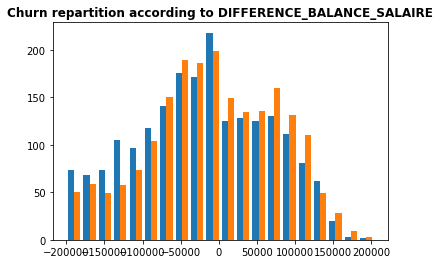

In [193]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([score0_diff_clients.sample(frac=churner_ratio)['DIFFERENCE_BALANCE_SALAIRE'],
         score0_diff_clients.query('CHURN == 1')['DIFFERENCE_BALANCE_SALAIRE']],bins=20)
plt.title(f'Churn repartition according to DIFFERENCE_BALANCE_SALAIRE', fontweight ="bold")

Column DIFFERENCE_BALANCE_SALAIRE doesn't seem to give more informations than BALANCE or SALAIRE.

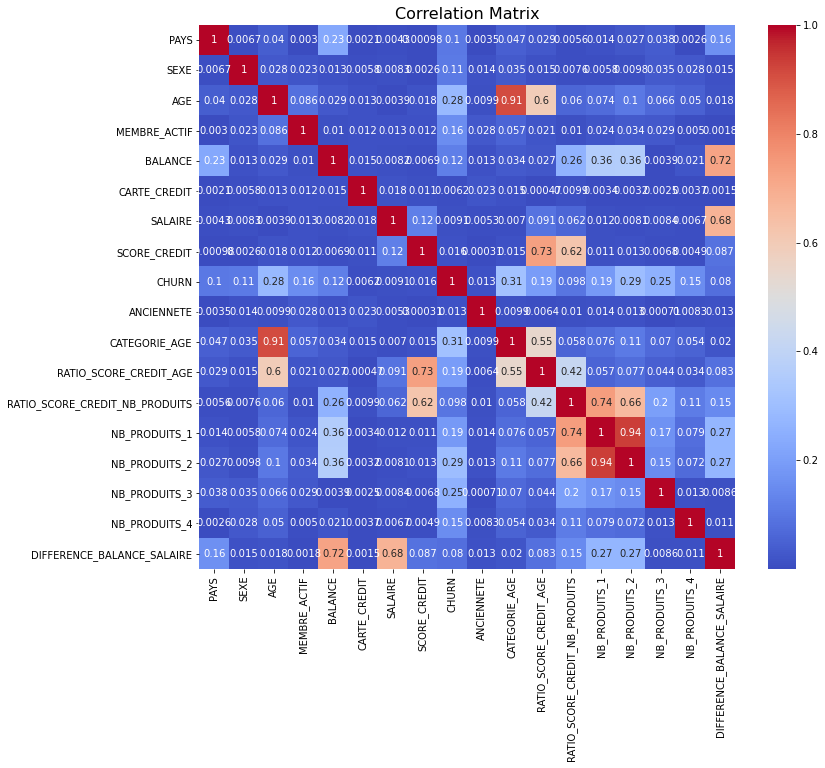

In [194]:
score0_diff_clients['CATEGORIE_AGE'] = score0_diff_clients['CATEGORIE_AGE'].astype(float)
fig = plt.figure(figsize=(12,10))
sns.heatmap(score0_diff_clients.corr().abs(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix', fontsize=16);

Nothing new to notice here.

## 4.3 Score 350

In [44]:
score350_clients = imputer_score350.fit_transform(clients)
score350_clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9950 entries, 0 to 9949
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   DATE_ENTREE                     9950 non-null   datetime64[ns]
 1   PAYS                            9950 non-null   float64       
 2   SEXE                            9950 non-null   int64         
 3   AGE                             9950 non-null   int64         
 4   MEMBRE_ACTIF                    9950 non-null   int64         
 5   BALANCE                         9950 non-null   float64       
 6   CARTE_CREDIT                    9950 non-null   int64         
 7   SALAIRE                         9721 non-null   float64       
 8   SCORE_CREDIT                    9950 non-null   float64       
 9   CHURN                           9950 non-null   int64         
 10  ANCIENNETE                      9950 non-null   int64         
 11  CATE

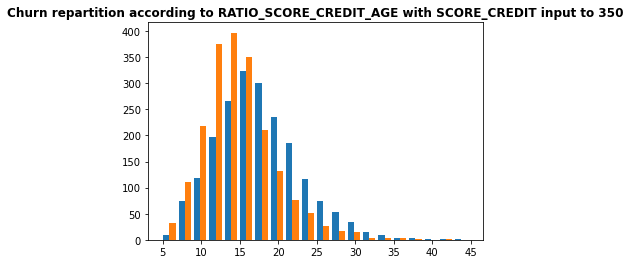

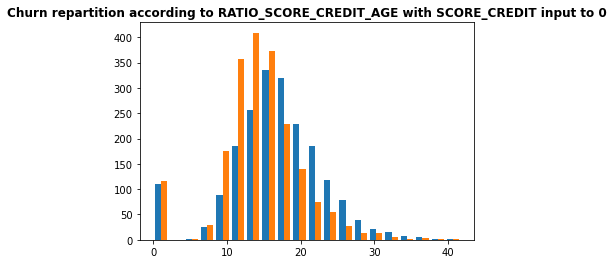

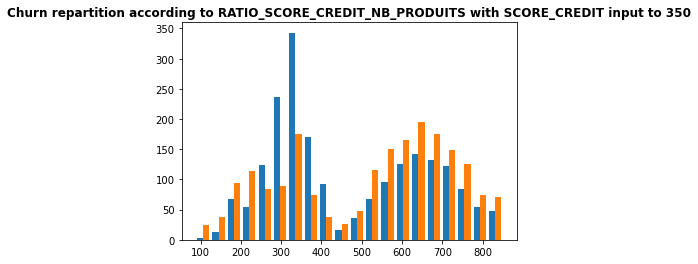

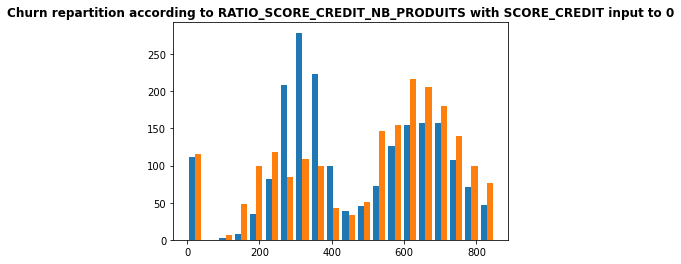

In [198]:
for column in ['RATIO_SCORE_CREDIT_AGE', 'RATIO_SCORE_CREDIT_NB_PRODUITS']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist([score350_clients.sample(frac=churner_ratio)[column],
             score350_clients.query('CHURN == 1')[column]],bins=20)
    plt.title(f'Churn repartition according to {column} with SCORE_CREDIT input to 350', fontweight ="bold")
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist([score0_ratio_clients.sample(frac=churner_ratio)[column],
             score0_ratio_clients.query('CHURN == 1')[column]],bins=20)
    plt.title(f'Churn repartition according to {column} with SCORE_CREDIT input to 0', fontweight ="bold")

Not enough information to choose between the two options. Try both of them and see!

## 4.4 Feature engineering conclusion

- Ratios credit score over age and product number seem interesting to create.
- Ratio balance over wage doesn't and neither the difference of balance and wage.
- We could try to use age classes.
- Chose 0 over 350 for credit score imputing should not make a huge difference.